In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os, sys

# sys.path.append("~/X/PythonForDataScience/air_traffic_project/submissions/first_real_submission/")

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
import geopy.distance
from sklearn.metrics import mean_squared_error
from model_selection_python import *
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

from estimator_web import _merge_external_data
# from estimator_all_features import _merge_external_data
# from estimator import _merge_external_data

from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError

from xgboost import XGBRegressor, XGBRFRegressor
import xgboost as xgb


pd.set_option('display.max_columns', None)

In [2]:
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgbrf_reg(self, para):
        reg = xgb.XGBRFRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    
    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

def power_2(x):
    return np.power(x, 2)

def inv_fct(x):
    return 1/x

## Loading Data

In [3]:
X_train, y_train = get_train_data('..')
X_test, y_test = get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

Merge 1 with dates: (8902, 21)
Merge after first date booked merge: (8902, 22)
Merge after second date booked merge: (8902, 23)
Merge dep dep with dates: (8902, 57)
Merge dep arr with dates: (8902, 87)


/Users/Hugo/Desktop/X-HEC/Polytechnique/Semestre 1/Python_For_Data_Science/air_traffic_project/src/estimator_web.py:31: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


Merge last with dates: (8902, 85)
Merge 1 with dates: (2226, 21)
Merge after first date booked merge: (2226, 22)
Merge after second date booked merge: (2226, 23)
Merge dep dep with dates: (2226, 57)
Merge dep arr with dates: (2226, 87)
Merge last with dates: (2226, 85)


In [4]:
X_train_merged.head()

,Departure,Arrival,WeeksToDeparture,std_wtd,Days_to_departure,route_mean,year_departure,day_departure,n_days_departure,day_nb_mean,day_mean,week_mean,month_mean,oil_stock_price,oil_stock_volume,AAL_stock_price,AAL_stock_volume,SP_stock_price,SP_stock_volume,search_intensity_booked_dep,search_intensity_booked_arr,Max TemperatureC_dep,Mean TemperatureC_dep,Min TemperatureC_dep,Dew PointC_dep,MeanDew PointC_dep,Min DewpointC_dep,Max Humidity_dep,Mean Humidity_dep,Min Humidity_dep,Max Sea Level PressurehPa_dep,Mean Sea Level PressurehPa_dep,Min Sea Level PressurehPa_dep,Max VisibilityKm_dep,Mean VisibilityKm_dep,Min VisibilitykM_dep,Max Wind SpeedKm/h_dep,Mean Wind SpeedKm/h_dep,CloudCover_dep,WindDirDegrees_dep,LoadFactorDomestic_dep,PassengersDomestic_dep,latitude_deg_dep,longitude_deg_dep,pop2010_dep,UnemploymentRate_dep,holidays_dep,GDP_per_cap_dep,closest_holidays_dep,total_arr,flights_arr,booth_arr,mean_per_flight_arr,search_intensity_dep,Max TemperatureC_arr,Mean TemperatureC_arr,Min TemperatureC_arr,Dew PointC_arr,MeanDew PointC_arr,Min DewpointC_arr,Max Humidity_arr,Mean Humidity_arr,Min Humidity_arr,Max Sea Level PressurehPa_arr,Mean Sea Level PressurehPa_arr,Min Sea Level PressurehPa_arr,Max VisibilityKm_arr,Mean VisibilityKm_arr,Min VisibilitykM_arr,Max Wind SpeedKm/h_arr,Mean Wind SpeedKm/h_arr,CloudCover_arr,WindDirDegrees_arr,LoadFactorDomestic_arr,PassengersDomestic_arr,latitude_deg_arr,longitude_deg_arr,pop2010_arr,UnemploymentRate_arr,holidays_arr,GDP_per_cap_arr,closest_holidays_arr,search_intensity_arr,distance,day_nb
0,ORD,DFW,12.875000,9.812647,90.0,11.919010,2012,19,15510,11.2038,11.080302,11.301741,11.240980,84.029999,109008.000000,12.70,1.164740e+07,1357.979980,3.815350e+09,58.0,55.0,35.0,31.0,26.0,20.0,18.0,17.0,62.0,51.0,39.0,1014.0,1012.0,1009.0,16.0,16.0,16.0,37.0,25.0,1.0,208.0,88.14,2480870,41.978600,-87.904800,2697530.0,8.7,True,50304.0,16.0,6599.0,60.0,250.0,109.98,82.0,34.0,29.0,24.0,22.0,21.0,19.0,82.0,63.0,44.0,1012.0,1010.0,1009.0,16.0,16.0,16.0,48.0,29.0,5.0,161.0,88.65,2276172,32.896801,-97.038002,1200370.0,7.0,True,47417.0,1.0,49.0,1290.346797,170
1,LAS,DEN,14.285714,9.466734,100.0,10.451326,2012,10,15593,10.7688,11.316519,11.282255,11.163944,96.540001,221996.000000,12.00,9.006400e+06,1429.079956,3.223670e+09,74.0,51.0,36.0,32.0,27.0,16.0,13.0,10.0,51.0,36.0,21.0,1011.0,1009.0,1005.0,16.0,15.0,11.0,32.0,18.0,5.0,187.0,84.68,1500764,36.080101,-115.152000,584606.0,11.8,False,44589.0,8.0,848.0,8.0,28.0,106.00,47.0,33.0,25.0,16.0,-2.0,-6.0,-8.0,21.0,14.0,7.0,1011.0,1008.0,1005.0,16.0,16.0,16.0,35.0,15.0,3.0,207.0,85.74,2073285,39.861698,-104.672997,603354.0,8.0,False,49254.0,8.0,41.0,1011.046677,253
2,DEN,LAX,10.863636,9.035883,76.0,11.049831,2012,5,15618,11.5286,11.221390,11.210159,11.243521,89.879997,279131.000000,11.66,6.819600e+06,1460.930054,3.172940e+09,86.0,37.0,6.0,2.0,-1.0,0.0,-2.0,-4.0,92.0,76.0,60.0,1027.0,1023.0,1020.0,16.0,9.0,1.0,27.0,15.0,7.0,357.0,87.27,2136379,39.861698,-104.672997,603354.0,7.9,False,49254.0,4.0,19164.0,95.0,852.0,201.73,40.0,22.0,19.0,16.0,17.0,16.0,14.0,93.0,77.0,61.0,1018.0,1016.0,1014.0,16.0,13.0,8.0,24.0,8.0,5.0,266.0,84.94,1872910,33.942501,-118.407997,3795370.0,10.1,False,51871.0,4.0,32.0,1387.023784,278
3,ATL,ORD,11.480000,7.990202,80.0,11.300291,2011,9,15256,11.2015,10.812631,11.210159,11.243521,84.600004,302396.666667,5.29,4.963567e+06,1181.746664,4.824660e+09,42.0,77.0,22.0,19.0,16.0,12.0,10.0,6.0,67.0,56.0,44.0,1026.0,1024.0,1021.0,16.0,16.0,16.0,37.0,26.0,8.0,70.0,85.20,3511352,33.636700,-84.428101,429193.0,10.2,False,42029.0,2.0,12806.0,69.0,349.0,185.59,35.0,27.0,19.0,11.0,12.0,10.0,9.0,83.0,58.0,33.0,1028.0,1026.0,1024.0,16.0,16.0,16.0,23.0,6.0,1.0,93.0,86.55,2417073,41.978600,-87.904800,2697530.0,10.1,False,50304.0,2.0,59.0,974.957144,282
4,DEN,SFO,11.450000,9.517159,80.0,10.822171,2012,21,15391,11.3304,11.080302,10.950214,10.926466,105.839996,316239.000000,7.89,1.533480e+07,1362.209961,3.795200e+09,62.0,47.0,8.0,2.0,-4.0,-6.0,-9.0,-13.0,46.0,39

In [5]:
X_train_merged.columns[X_train_merged.isna().any()].tolist()

[]

In [6]:
X_train_merged.isna().sum()

Departure               0
Arrival                 0
WeeksToDeparture        0
std_wtd                 0
Days_to_departure       0
                       ..
GDP_per_cap_arr         0
closest_holidays_arr    0
search_intensity_arr    0
distance                0
day_nb                  0
Length: 85, dtype: int64

In [7]:
X_train_data = X_train_merged
X_test_data = X_test_merged

In [8]:
X_train_data.drop(['Departure', 'Arrival', 'holidays_dep', 'holidays_arr'], axis=1, inplace=True)
X_test_data.drop(['Departure', 'Arrival', 'holidays_dep', 'holidays_arr'], axis=1, inplace=True)

In [9]:
# features_to_keep = ['WeeksToDeparture', 'std_wtd', 'route_mean',
#        'day_departure', 'n_days_departure', 'day_nb_mean',
#        'day_mean', 'week_mean', 'oil_stock_price',
#        'oil_stock_volume', 'AAL_stock_price', 'AAL_stock_volume',
#        'SP_stock_price', 'SP_stock_volume', 'search_intensity_booked_dep',
#        'search_intensity_booked_arr', 'Max TemperatureC_dep',
#        'Min TemperatureC_dep', 'Dew PointC_dep',
#        'Min DewpointC_dep', 'Max Humidity_dep',
#        'Mean Humidity_dep', 'Min Humidity_dep',
#        'Max Sea Level PressurehPa_dep', 'Mean Sea Level PressurehPa_dep',
#        'Min Sea Level PressurehPa_dep',
#        'Max Wind SpeedKm/h_dep', 'Mean Wind SpeedKm/h_dep', 'CloudCover_dep',
#        'WindDirDegrees_dep', 'LoadFactorDomestic_dep',
#        'PassengersDomestic_dep',
#        'UnemploymentRate_dep',
#        'closest_holidays_dep', 'total_arr', 'flights_arr', 'booth_arr',
#        'mean_per_flight_arr', 'search_intensity_dep', 'Max TemperatureC_arr',
#        'Min DewpointC_arr', 'Max Humidity_arr',
#        'Mean Humidity_arr', 'Min Humidity_arr',
#        'Max Sea Level PressurehPa_arr',
#        'Min Sea Level PressurehPa_arr',
#        'Max Wind SpeedKm/h_arr', 'Mean Wind SpeedKm/h_arr', 'CloudCover_arr',
#        'WindDirDegrees_arr', 'LoadFactorDomestic_arr',
#        'PassengersDomestic_arr',
#        'UnemploymentRate_arr',
#        'closest_holidays_arr', 'search_intensity_arr', 'distance', 'day_nb']

# X_train_data = X_train_data[features_to_keep]
# X_test_data = X_test_data[features_to_keep]

## Modelling

In [10]:
from hyperopt import hp

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.01, 0.7, 0.01)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(1000, 8000, 1000)),
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
# xgb_para['learning_rate'] = 0.075
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# Feature Engineering STD_WTD
# X_train_data['std_wtd_log'] = X_train_data['std_wtd'].transform(np.log)
# X_train_data['std_wtd_inv'] = X_train_data['std_wtd'].transform(inv_fct)

# X_test_data['std_wtd_log'] = X_test_data['std_wtd'].transform(np.log)
# X_test_data['std_wtd_inv'] = X_test_data['std_wtd'].transform(inv_fct)

obj = HPOpt(X_train_data, X_test_data, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

results, trials = xgb_opt

print(results)


100%|██████████| 100/100 [16:35<00:00,  9.96s/trial, best loss: 0.32113321780829]  
{'colsample_bytree': 4, 'learning_rate': 1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 4, 'subsample': 0.7421221257404762}


## Testing

RMSE: 0.317660


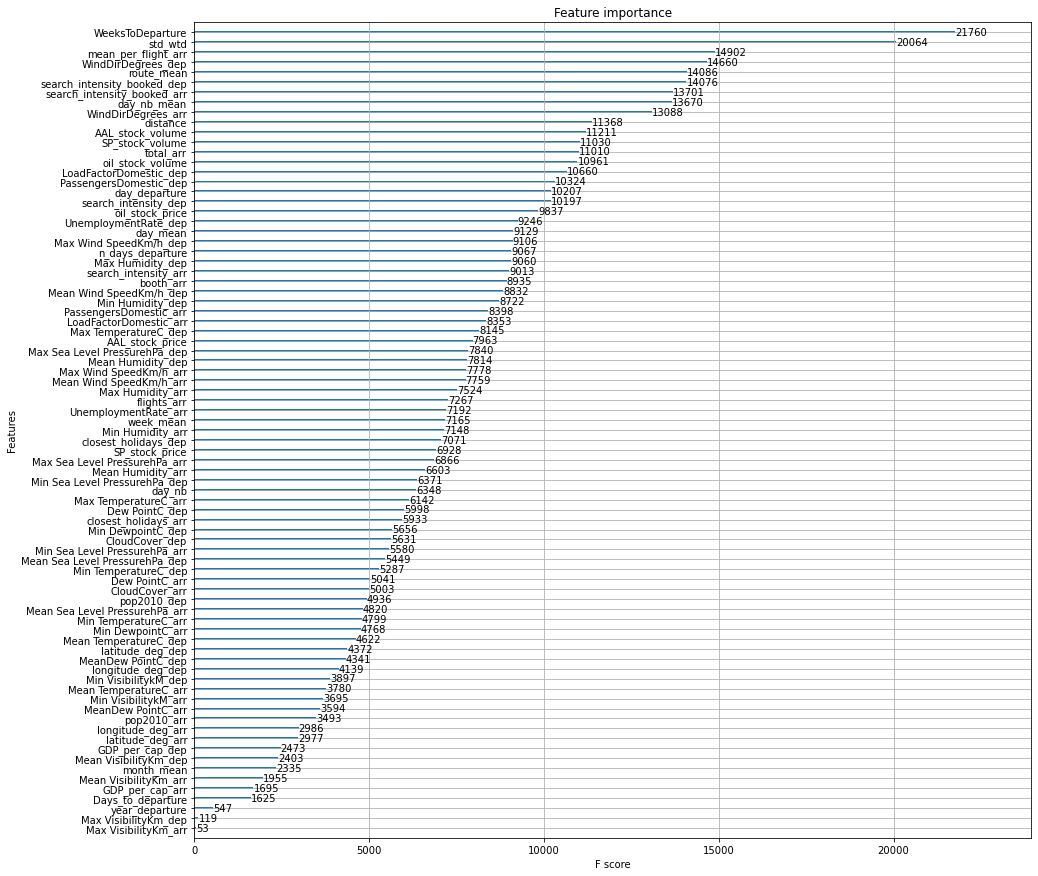

In [11]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.9, learning_rate=0.01, 
                          n_estimators=5000, max_depth=8, min_child_weight=3, subsample=0.8666220148202693, booster='gbtree')

xg_reg.fit(X_train_data, y_train)

preds = xg_reg.predict(X_test_data)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

plt.rcParams['figure.figsize'] = [15, 15]
xgb.plot_importance(xg_reg)
plt.show()


In [12]:
# xgb_reg_params = {
#     'learning_rate':    hp.choice('learning_rate',    np.arange(0.01, 0.1, 0.01)),
#     'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
#     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
#     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
#     'subsample':        hp.uniform('subsample', 0.8, 1),
#     'n_estimators':     hp.choice('n_estimators', np.arange(5000, 10000, 1000)),
# }
